In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import date

___
**SOURCE**:

Hello, in this notebook we will be exploring the effects of government decisions on the # of daily new covid cases.

* The dataset can be downloaded here [Dataset](https://www.donneesquebec.ca/recherche/dataset/covid-19-portrait-quotidien-des-cas-confirmes)



In [20]:
# Let's import the dataset
covid = pd.read_csv('COVID19_Qc_RapportINSPQ_HistoVigie.csv')

# Notice that the date at row 0 is invalid...let's update the value
covid.at[0, 'Date'] =  '2020-01-22'

# We can now convert the column 'Date' to datetime type
covid.Date = pd.to_datetime(covid.Date)

In [65]:
df1 = covid.loc[covid.Date <= '2021-05-01']

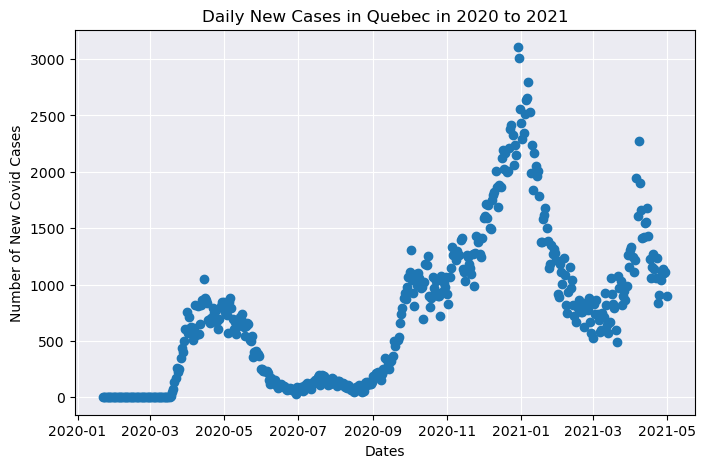

In [70]:
fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df1.Date, df1.Nb_Nvx_Cas, zorder=2)
ax.set_xlabel('Dates')
ax.set_ylabel('Number of New Covid Cases')
ax.set_title('Daily New Cases in Quebec in 2020 to 2021');

ax.grid(zorder=1)
ax.grid(color='white')
ax.set_facecolor((0.92,0.92,0.95))


# view of total dataset

## Distribution of y (Number of Covid Cases)

Before training any model on the data, it is interesting to examine the distribution shape of the $y$ variable.

In [23]:
make_df = lambda date1,date2: covid.loc[(covid.Date >= date1) & (covid.Date <= date2)] 
# a function to call to our covid data dataframe with date filters through using lambda.

# get our temporary dataframe for each event
lock1 = make_df('2020-03-01', '2020-05-30')
reop = make_df('2020-07-07', '2020-10-07')
lock2 = make_df('2020-10-31', '2021-04-30')


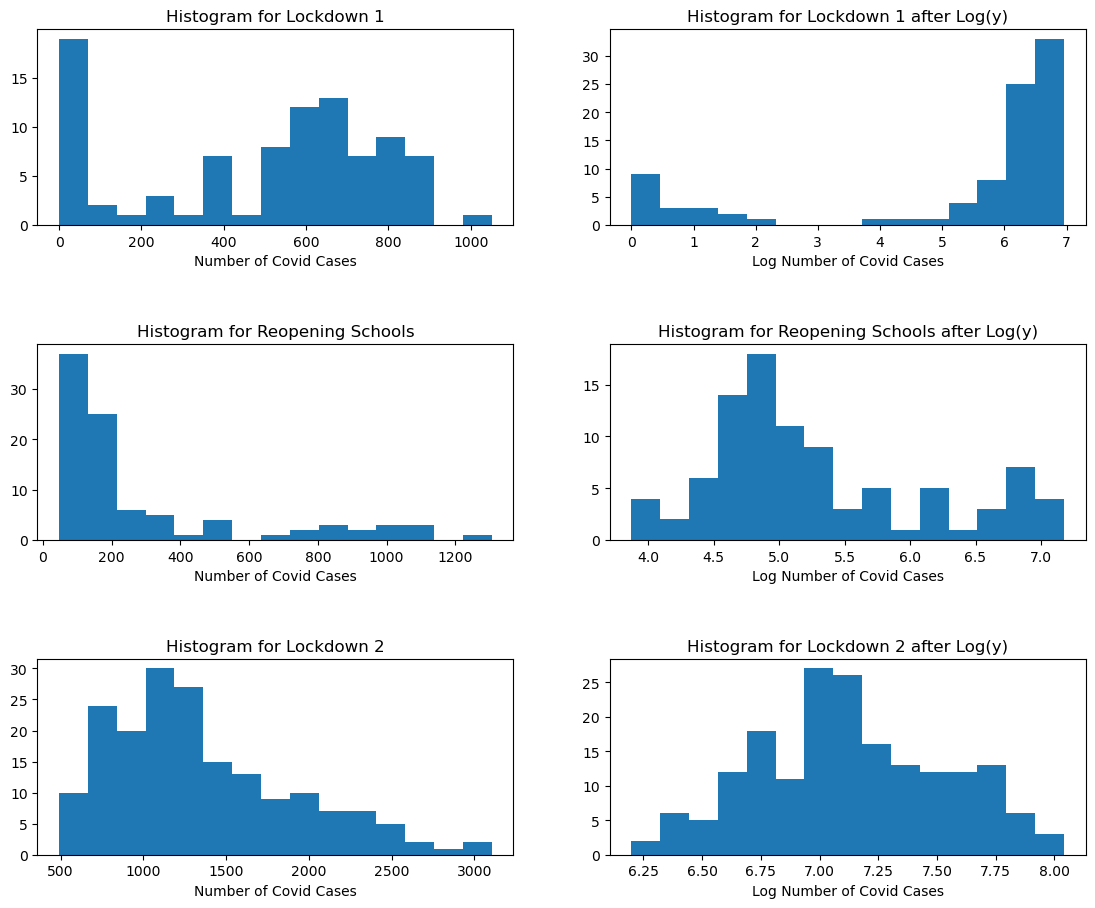

In [72]:
# Let's visualize the distribution of our daily new cases.

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 10))

# --- Histogram for Lockdown 1
ax1[0].hist(lock1.Nb_Nvx_Cas, bins = 15)
ax1[0].set_xlabel('Number of Covid Cases')
ax1[0].set_title('Histogram for Lockdown 1')

# apply log-transformation
ax1[1].hist(lock1.Nb_Nvx_Cas.apply(np.log1p), bins = 15)       
ax1[1].set_xlabel('Log Number of Covid Cases')
ax1[1].set_title('Histogram for Lockdown 1 after Log(y)')


# --- Histogram for Reopening Schools
ax2[0].hist(reop.Nb_Nvx_Cas, bins = 15)
ax2[0].set_xlabel('Number of Covid Cases')
ax2[0].set_title('Histogram for Reopening Schools')

# apply log-transformation
ax2[1].hist(reop.Nb_Nvx_Cas.apply(np.log1p), bins = 15)
ax2[1].set_xlabel('Log Number of Covid Cases')
ax2[1].set_title('Histogram for Reopening Schools after Log(y)')


# --- Histogram for Lockdown 2
ax3[0].hist(lock2.Nb_Nvx_Cas, bins = 15)
ax3[0].set_xlabel('Number of Covid Cases')
ax3[0].set_title('Histogram for Lockdown 2')

# apply log-transformation
ax3[1].hist(lock2.Nb_Nvx_Cas.apply(np.log1p), bins = 15)
ax3[1].set_xlabel('Log Number of Covid Cases')
ax3[1].set_title('Histogram for Lockdown 2 after Log(y)')

fig = plt.tight_layout(pad = 4.)
plt.show()

From the plots above, we observe that the values of the variable $y$ (which is the `number of Covid cases` in our scenario)  is not normally distributed for the three different events. Hence, using a log-transformation on $y$ helps normalizing the shape of the distribution. Linear Regression model may also fit better the data if $y$ has been rescaled.

## Building RDD model

For constructing a RDD model, we will use the following equation [source](https://en.wikipedia.org/wiki/Regression_discontinuity_design)

$y = b0 + b1  x + b2[k>j] + b3[k>j]x$

where
* $b0$: constant for first part of RDD (before thresold)
* $b1$: slope for first part of RDD (before thresold)
* $b2$: constant for second part of RDD (after thresold)
* $b3$: slope for second part of RDD (after thresold)
* $[k>j]$ : Dummy variable which verifies whether variable $x$ is located after/before the date thresold


In [25]:
def get_df(dates_event, threshold = 14):
    
    '''
    This functions creates dataframe in the range from given dates and threshold
    '''
    
    # update thresold
    d0 = pd.to_datetime(dates_event[0], format='%Y/%m/%d')
    d1 = pd.to_datetime(dates_event[1], format='%Y/%m/%d')
    threshold = (d1 - d0).days + threshold
    
    # select rows in the given range of dates
    df = covid.loc[(covid.Date >= dates_event[0]) & (covid.Date <= dates_event[2])][['Date','Nb_Nvx_Cas']]
    
    # count the number of days starting from day 1 at the first date of the range
    df.insert(1, 'Days', range(1, 1 + len(df)))
    
    # Dummy variable 
    df['Threshold'] = df.Days.apply(lambda x: int(threshold < x))
    df['Days:Threshold'] = df.Days * df['Threshold']
    
    # apply log-transformation on y
    df['Nb_Nvx_Cas'] = df['Nb_Nvx_Cas'].apply(np.log1p) # np.log1P calculates the natural log (ln) of new cases +1
    
    return df

In [71]:
def get_df_poly(dates_event, threshold = 14):
    
    '''
    This functions creates dataframe in the range from given dates and threshold
    '''
    
    # update thresold
    d0 = pd.to_datetime(dates_event[0], format='%Y/%m/%d')
    d1 = pd.to_datetime(dates_event[1], format='%Y/%m/%d')
    threshold = (d1 - d0).days + threshold
    
    # select rows in the given range of dates
    df = covid.loc[(covid.Date >= dates_event[0]) & (covid.Date <= dates_event[2])][['Date','Nb_Nvx_Cas']]
    
    # count the number of days starting from day 1 at the first date of the range
    df.insert(1, 'Days', range(1, 1 + len(df)))
    
    # Dummy variable 
    df['Threshold'] = df.Days.apply(lambda x: int(threshold < x))
    df['Days:Threshold'] = df.Days * df['Threshold']
    
    # apply log-transformation on y
    df['Nb_Nvx_Cas_poly'] = np.power(df['Nb_Nvx_Cas'], 2)
    
    return df

In [54]:
# set range of dates for each event
dates_lock1 = ['2020-03-01', '2020-03-20','2020-06-20']
dates_reop = ['2020-07-07', '2020-08-31','2020-10-07']
dates_lock2 = ['2020-10-31', '2020-12-25', '2021-03-10']



# create df for each events with 7 days as threshold
lockdown1_t7 = get_df(dates_lock1, 7)
reopening_schools_t7 = get_df(dates_reop, 7)
lockdown2_t7 = get_df(dates_lock2, 7)

# create df for each events with 14 days as threshold
lockdown1_t14 = get_df(dates_lock1, 14)
reopening_schools_t14 = get_df(dates_reop, 14)
lockdown2_t14 = get_df(dates_lock2, 14)

lockdown1_t7_poly = get_df_poly(dates_lock1, 7)

In [55]:
lockdown1_t7_poly

,Date,Days,Nb_Nvx_Cas,Threshold,Days:Threshold
39,2020-03-01,1,2,0,0
40,2020-03-02,2,2,0,0
41,2020-03-03,3,2,0,0
42,2020-03-04,4,2,0,0
43,2020-03-05,5,2,0,0
...,...,...,...,...,...
146,2020-06-16,108,102,1,108
147,2020-06-17,109,113,1,109
148,2020-06-18,110,101,1,110
149,2020-06-19,111,98,1,111


In [56]:
lockdown1_t7

,Date,Days,Nb_Nvx_Cas,Threshold,Days:Threshold
39,2020-03-01,1,0.000000,0,0
40,2020-03-02,2,0.000000,0,0
41,2020-03-03,3,0.000000,0,0
42,2020-03-04,4,0.000000,0,0
43,2020-03-05,5,0.000000,0,0
...,...,...,...,...,...
146,2020-06-16,108,4.615121,1,108
147,2020-06-17,109,4.753590,1,109
148,2020-06-18,110,4.644391,1,110
149,2020-06-19,111,4.574711,1,111


In [45]:
def get_est(df):
    '''
    This function returns the estimate Linear Regression model 
    '''
    
    # Let X, Y
    X = df[['Days','Threshold','Days:Threshold']]
    X = sm.add_constant(X)
    Y = df.Nb_Nvx_Cas
    
    # train model
    est = sm.OLS(Y,X).fit(cov_type = 'HC2')
    return est




In [46]:
# train models
est_lock1 = get_est(lockdown1_t14)
est_reop = get_est(reopening_schools_t14)
est_lock2 = get_est(lockdown2_t14)

## Summary of the models

In [47]:
# Summary for the Linear Regression model of Lockdown 1
est_lock1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     264.1
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           1.45e-49
Time:                        12:59:07   Log-Likelihood:                -89.864
No. Observations:                 112   AIC:                             187.7
Df Residuals:                     108   BIC:                             198.6
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.5595      0.302     -5.172      0.000      -2.150      -0.969
Days               0.2626      0.013     20.043      0.000       0.237       0.288
Threshold          9.5573      0.346     27.626      0.000       8.879      10.235
Days:Threshold    -0.2888      0.013    -21.714      0.000      -0.315      -0.263
==============================================================================
Omnibus:                        2.109   Durbin-Watson:                   0.260
Prob(Omnibus):                  0.348   Jarque-Bera (JB):                2.074
Skew:                          -0.324   Prob(JB):                        0.354
Kurtosis:                       2.840   Cond. No.                         566.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [48]:
# Summary for the Linear Regression model of reopening schools
est_reop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     288.8
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           9.75e-46
Time:                        12:59:07   Log-Likelihood:                -36.221
No. Observations:                  93   AIC:                             80.44
Df Residuals:                      89   BIC:                             90.57
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.6809      0.075     62.007      0.000       4.533       4.829
Days               0.0051      0.002      2.085      0.037       0.000       0.010
Threshold         -2.9993      0.562     -5.337      0.000      -4.101      -1.898
Days:Threshold     0.0544      0.007      7.365      0.000       0.040       0.069
==============================================================================
Omnibus:                        8.813   Durbin-Watson:                   0.459
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.860
Skew:                          -0.604   Prob(JB):                       0.0119
Kurtosis:                       3.910   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# Summary for the Linear Regression model of Lockdown 2
est_lock2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     380.4
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           2.98e-63
Time:                        12:59:07   Log-Likelihood:                 77.647
No. Observations:                 131   AIC:                            -147.3
Df Residuals:                     127   BIC:                            -135.8
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.8734      0.033    210.571      0.000       6.809       6.937
Days               0.0149      0.001     20.590      0.000       0.014       0.016
Threshold          2.0974      0.123     16.993      0.000       1.856       2.339
Days:Threshold    -0.0350      0.001    -25.036      0.000      -0.038      -0.032
==============================================================================
Omnibus:                        0.826   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.886
Skew:                          -0.184   Prob(JB):                        0.642
Kurtosis:                       2.834   Cond. No.                         893.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

## Graphs

In [50]:
def plot_rdd(df, dates_event, threshold, ax):
    
    '''
    This function plots the predicted line of RDD for given event in the given range of dates
    '''
    
    # update the threshold
    d0 = pd.to_datetime(dates_event[0], format='%Y/%m/%d')
    d1 = pd.to_datetime(dates_event[1], format='%Y/%m/%d')
    threshold = (d1 - d0).days + threshold
    
    # get x_hat and x_plot from df
    x_plot = pd.DataFrame({'x': list(range(1,len(df)+1))})   # this x is used for plotting
    x_hat = df[['Days','Threshold','Days:Threshold']]        # this x is used for training and predicting    
    x_hat = sm.add_constant(x_hat)
    
    # train Linear Regression model
    Y = df.Nb_Nvx_Cas
    est_model = sm.OLS(Y, x_hat).fit(cov_type = 'HC2')
    
    # get the coefficients from the estimate model
    beta0 = est_model.params['const']
    beta1 = est_model.params['Days']
    beta2 = est_model.params['Threshold']
    beta3 = est_model.params['Days:Threshold']
    
    
    # make predictions witht the estimate model
    y_hat = est_model.predict(x_hat)
    
    # make a discontinuous plot by removing the connection between the two parts of RDD 
    y_hat.iloc[threshold] = np.nan
    
    # get the extended line from the second part of RDD starting from the threshold
    x2 = pd.DataFrame({'x':[threshold, threshold + 3]})
    y2 = beta0 + beta1*x2 + beta2 + beta3*x2
    
    # plot RDD
    ax.plot(x_plot, y_hat, color = 'red', lw = 2)
    ax.plot(x2, y2 , color = 'red', lw = 2)
    ax.axvline(x = threshold, color = 'black', linestyle = 'dashed')
    

In [51]:
def plot_scatter(df, ax):
    
    '''
    This functions plots the scatter plot from given dataframe on the location of ax
    '''
    ax.scatter(df.Days, df.Nb_Nvx_Cas, alpha = 0.3)
    ax.set(xlabel = 'Days',
           ylabel = 'Log Number of Covid Cases')
    

## RDD Graphs

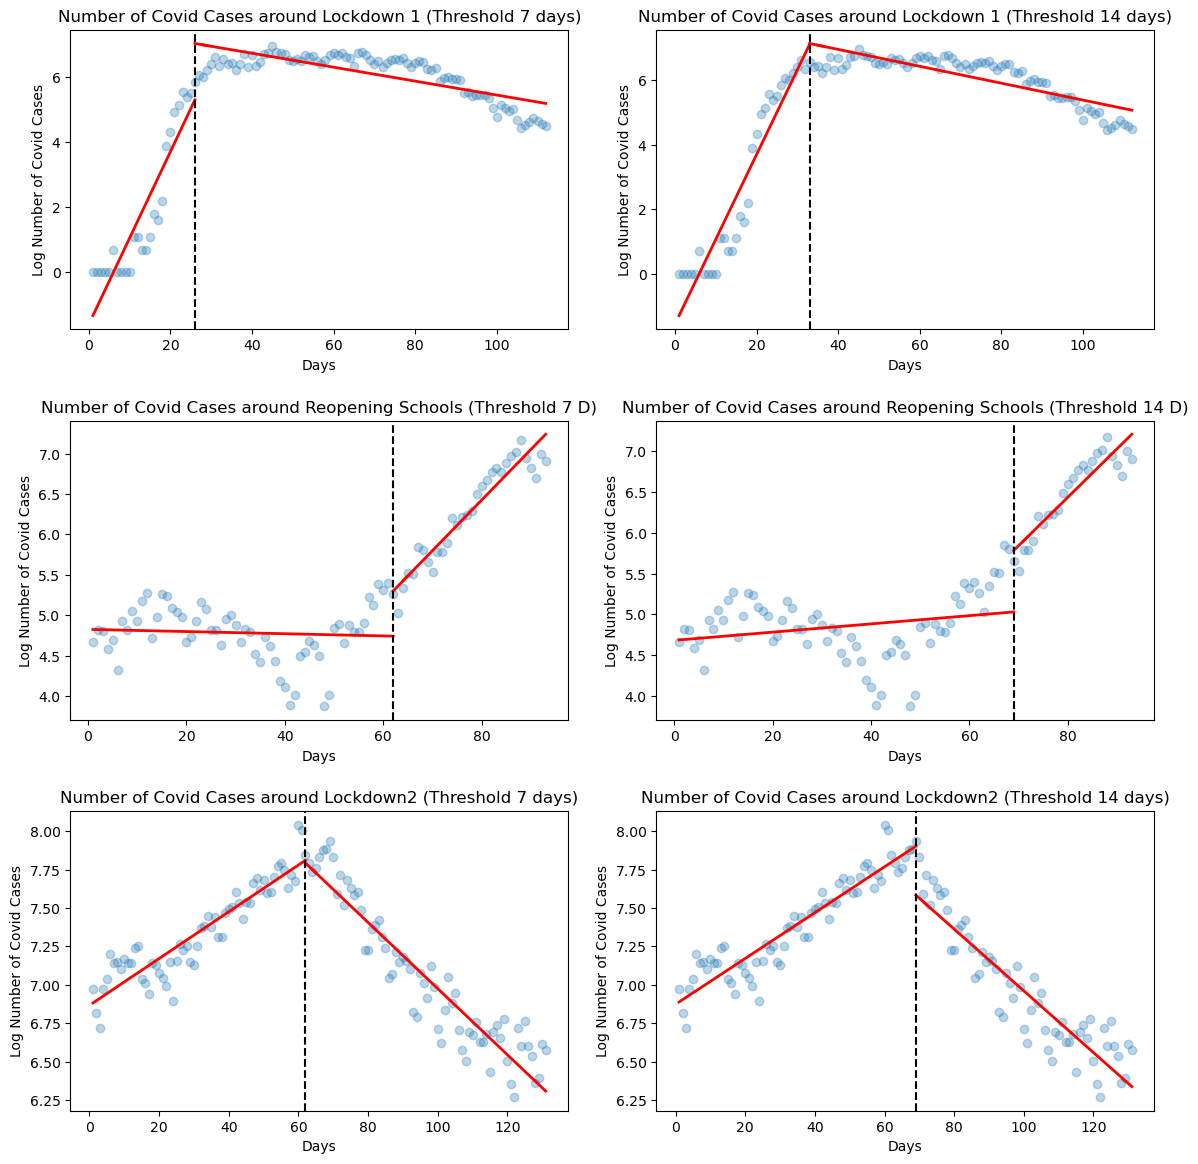

In [52]:

# plot RDD
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))


# --- Lockdown 1
# RDD with Threshold = 7 days
plot_scatter(lockdown1_t7, ax1[0])
plot_rdd(lockdown1_t7, dates_lock1, 7, ax1[0])
ax1[0].set_title('Number of Covid Cases around Lockdown 1 (Threshold 7 days)')

# RDD with Threshold = 14 days
plot_scatter(lockdown1_t14, ax1[1])
plot_rdd(lockdown1_t14, dates_lock1, 14, ax1[1])
ax1[1].set_title('Number of Covid Cases around Lockdown 1 (Threshold 14 days)')


# --- Reopening Schools
# RDD with Threshold = 7 days
plot_scatter(reopening_schools_t7, ax2[0])
plot_rdd(reopening_schools_t7, dates_reop, 7, ax2[0])
ax2[0].set_title('Number of Covid Cases around Reopening Schools (Threshold 7 D)')

# RDD with Threshold = 14 days
plot_scatter(reopening_schools_t14, ax2[1])
plot_rdd(reopening_schools_t14, dates_reop, 14, ax2[1])
ax2[1].set_title('Number of Covid Cases around Reopening Schools (Threshold 14 D)')


# --- Lockdown 2
# RDD with Threshold = 7 days
plot_scatter(lockdown2_t7, ax3[0])
plot_rdd(lockdown2_t7, dates_lock2, 7, ax3[0])
ax3[0].set_title('Number of Covid Cases around Lockdown2 (Threshold 7 days)')

# RDD with Threshold = 14 days
plot_scatter(lockdown2_t14, ax3[1])
plot_rdd(lockdown2_t14, dates_lock2, 14, ax3[1])
ax3[1].set_title('Number of Covid Cases around Lockdown2 (Threshold 14 days)')


fig.tight_layout(pad = 2)
plt.show()